# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

## Подготовка данных

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

### Загрузка данных и ознакомление

In [2]:
data = pd.read_csv('/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.shape

(10000, 14)

In [4]:
data.duplicated().sum()

0

In [5]:
(data.isnull().mean())*100

RowNumber          0.00
CustomerId         0.00
Surname            0.00
CreditScore        0.00
Geography          0.00
Gender             0.00
Age                0.00
Tenure             9.09
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.00
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64

In [6]:
data.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [7]:
data.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

**Вывод:** В данных отсутствиую явные дубликаты, но присутствуют пропуски в колонке Tenure. В датасете превалируют численные значения.

### Подготовим данные для решения задачи

Часть колонок следует исключить из дата сета, это: RowNumber,CustomerId и Surname.

RowNumber и CustomerId будут только сбивать с толку нашу будующую модель, а после преобразования данных OHE Surname нам вернёт огромное количество колонок, нам это не к чему.

In [8]:
data=data.drop(columns=['RowNumber','CustomerId','Surname'])

Пропуски в колонке Tenure заполним медианными значениями.

In [9]:
data['Tenure'].median()

5.0

In [10]:
data = data.fillna(data['Tenure'].median())
data.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### Разбивка данных на признаки и цели.

In [11]:
data_train, data_sep = train_test_split(data,train_size=0.6, test_size=0.4, random_state=12345)
data_valid, data_test = train_test_split(data_sep, test_size=0.5, random_state=12345)

In [12]:
data_train.shape

(6000, 11)

In [13]:
data_valid.shape

(2000, 11)

In [14]:
data_test.shape

(2000, 11)

In [15]:
features_train = data_train.drop(['Exited'], axis=1)
target_train = data_train['Exited']

In [16]:
features_valid = data_valid.drop(['Exited'], axis=1)
target_valid = data_valid['Exited']

In [17]:
features_test = data_test.drop(['Exited'], axis=1)
target_test = data_test['Exited']

In [18]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

### Масштабирование признаков

Выберем все колонки содержащие числовые значения.

In [19]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [20]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [21]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Исследование задачи

### Пробное обучение модели

In [22]:
model = DecisionTreeClassifier(random_state=12345).fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
accuracy_score(target_valid, predicted_valid)

0.7935

### Проверка адеквтности модели

In [23]:
class_freq = data['Exited'].value_counts(normalize=True)
class_freq

0    0.7963
1    0.2037
Name: Exited, dtype: float64

<AxesSubplot:>

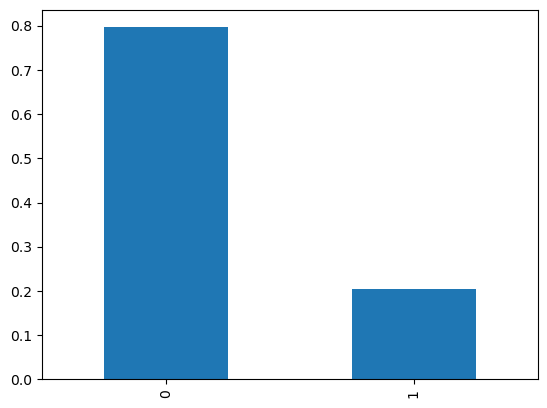

In [24]:
class_freq.plot(kind='bar')

Вывод: данные распределены не равномерно.

### Матрица ошибок

In [25]:
confusion_matrix(target_valid,predicted_valid)

array([[1380,  202],
       [ 211,  207]], dtype=int64)

**Вывод:** из 1380 правильных ответов только 202 предсказаний оказались корректыми.

### Рассмотрение метрик

**Полнота**

In [26]:
recall_score(target_valid,predicted_valid)

0.49521531100478466

**Точность**

In [27]:
precision_score(target_valid,predicted_valid)

0.5061124694376528

**F1-мера**

In [28]:
f1_score(target_valid,predicted_valid)

0.5006045949214026

**Вывод:** наши показатели почти близки к половине, но этого не достаточно.

Необходимо придать объектам редкого класса больший вес. В имеющихся данных это 1.

## Борьба с дисбалансом

Поскольку мы имеем дело с задачей классификации, используем случайный лес.

In [29]:
model = RandomForestClassifier(random_state=12345, class_weight='balanced').fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
f1_score(target_valid,predicted_valid)

0.5718701700154559

**Вывод:** f1-мера подросла.Проведем увеличение выборки.

In [30]:
def unsample(features, target, repeat):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    
    features_upsampled = pd.concat([features_zeros]+[features_ones]*repeat)
    target_upsamppled = pd.concat([target_zeros]+[target_ones]*repeat)
    return features_upsampled, target_upsamppled

features_upsampled, target_upsampled = unsample(features_train,target_train, 10)

features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

In [31]:
model = RandomForestClassifier(random_state=12345).fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)
f1_score(target_valid,predicted_valid)

0.5904761904761905

**Вывод:** метрика продолжает расти.

Подберем количество деревьев и глубину для улучшения показателей модели.

In [32]:
best_result = 0
best_depth = 0
for depth in range(1, 20, 1):
    model = RandomForestClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    prediction_valid = model.predict(features_valid)
    result = f1_score(target_valid,prediction_valid)
    if result > best_result:
        best_result = result
        best_depth = depth
print('Лучшая глубина:',best_depth, 'Лучший результат:', best_result)

Лучшая глубина: 14 Лучший результат: 0.6006904487917146


In [33]:
best_result = 0
best_est = 0
for est in range(1, 100, 10):
    model = RandomForestClassifier(n_estimators=est, max_depth=14, random_state=12345)
    model.fit(features_upsampled,target_upsampled)
    prediction_valid = model.predict(features_valid)
    result = f1_score(target_valid,prediction_valid)
    if result > best_result:
        best_result = result
        best_est = est
print('Лучшее количество деревьев:', best_est, 'Лучший результат:', best_result)

Лучшее количество деревьев: 91 Лучший результат: 0.6116838487972508


In [34]:
model = DecisionTreeClassifier(random_state=12345).fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)
f1_score(target_valid,predicted_valid)

0.46971569839307786

**Вывод:** лучший результат даёт Случайный лес.

## Тестирование модели

In [35]:
model = RandomForestClassifier(n_estimators=90, max_depth=14, random_state=12345).fit(features_upsampled, target_upsampled)
prediction_test = model.predict(features_test)
f1_score(target_test,prediction_test)

0.6011173184357542

In [36]:
proba_test = model.predict_proba(features_test)
proba_one_test = proba_test[:, 1]
roc_auc_score(target_test,proba_one_test)

0.8442901880009773

**Вывод:** После проведения исследования и подбора наиболее подходящих гиперпараметров случайного леса, лучший показатель f1-меры при количестве деревьев 90 и их глубине 14.